2023-11-26
2023-11-27
2023-11-28
2023-11-29
2023-11-30
2023-12-01
2023-12-02
2023-12-03
2023-12-04
2023-12-05
2023-12-06
2023-12-07


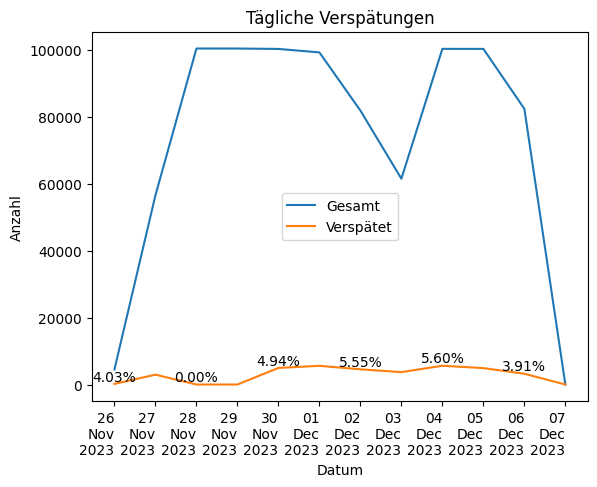

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pymysql
from datetime import date, timedelta

# Verbindung zur Datenbank herstellen
db = pymysql.connect(host="localhost", user="rnv_importer", password="rnv_importer", database="rnv_big_data_mining")
cursor = db.cursor()

# Daten sammeln
day = []
total = []
delayed = []

start_date = date(2023, 11, 26)
end_date = date.today()
delta = timedelta(days=1)

# Monat und Jahr zwischenspeichern
current_month = None
current_year = None

while start_date <= end_date:
    day.append(start_date)
    print(start_date)

    cursor.execute("SELECT COUNT(*) FROM stops WHERE DATE(api_plannedDeparture) = %s", start_date.strftime("%Y-%m-%d"))
    total.append(cursor.fetchone()[0])

    cursor.execute("SELECT COUNT(*) FROM stops WHERE DATE(api_plannedDeparture) = %s AND api_plannedDeparture != api_realtimeDeparture", start_date.strftime("%Y-%m-%d"))
    delayed.append(cursor.fetchone()[0])

    # Monat und Jahr überprüfen
    if start_date.month != current_month or start_date.year != current_year:
        current_month = start_date.month
        current_year = start_date.year

    start_date += delta

# DataFrame erstellen
df = pd.DataFrame({
    'Gesamt': total,
    'Verspätet': delayed
}, index=day)

# Plot erstellen
fig, ax = plt.subplots()
lines = df.plot.line(ax=ax)

# Text zu den Linien hinzufügen (nur bei der Linie "Verspätet" und jedem zweiten Tag)
for i, (dt, delayed_count) in enumerate(zip(day, delayed)):
    if i % 2 == 0 and total[i] != 0:  # Nur jeden zweiten Tag anzeigen und wenn die Gesamtanzahl nicht null ist
        percentage = (delayed_count / total[i]) * 100
        ax.text(dt, delayed_count, f'{percentage:.2f}%', ha='center', va='bottom')

# Achsentitel und Diagrammtitel hinzufügen
plt.xlabel('Datum')
plt.ylabel('Anzahl')
plt.title('Tägliche Verspätungen')

# X-Achsenticks anpassen
plt.xticks(day, [f'{d.strftime("%d")}\n{d.strftime("%b")}\n{d.strftime("%Y")}' for d in day], rotation=0, ha='right')

# Legende anzeigen
ax.legend()

# Diagramm anzeigen
plt.show()